# Lab 1

The aims of the lab are to:
*   Introduce you to colab, verify that you're setup with the correct python packages
*   Introduce you to NLTK and Pandas libraries
*   Learn to perform text processing using NLTK: tokenization, normalization, and segmentation of text 
*   Calculate basic collection statistics of a corpus of text
*   Become familiar with the structure of the Reddit data collection





## Colab Introduction


Colab is an improved(?) Jupyter Notebook.  It is used internally by engineers and researchers at Google to prototype and share experimental results. 

It supports:

1. Text Cells with [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) formatting
2. Code Cells
3. Notebook stores code, output, and execution order
4. Tab and Tab + Tab Autocomplete
5. IPython Help Features
6. IPython Magics (`%%`)

### Additional Features

- collaborative editing
- history 
- comments
- executed code history
- Shift+click multiple cell selection
- searchable code snipetts + table of contents
- scratchpad (⌘/Ctrl + Alt + N)

### Keyboard Shortcuts
| Command | Action |
| ---- | ----: |
|⌘/Ctrl+Enter | Run Selected Cell |
|Shift+Enter| Run Cell and Select Next |
|Alt+Enter| Run cell and insert new cell|
|⌘/Ctrl+M I | Interrupt Execution |

- You can open the command Palette to see all shortcuts by going to Tools --> Command palette.

### Summary of tips
- Use TAB to autocomplete an expression. 
- You can also execute the code with a ? to get the doc strings
- In Jupyter / Colab you can execute shell commands using `!`, example: "!ls" to list the current files.


*Note:* Occassionally colab may hang or crash (due to cloud flakiness or (sometimes) bad code).  You can control the execution using the Runtime menu to reboot and start fresh.  To resume where you left off you can click "Run before" and it will run all cells before the one currently selected.


*Note:* You can use Colab with a cloud VM or connect to a local Jupyter instance.



### Getting help example

Let's get some help with the Pandas library we'll be using later.  The DataFrame is the main data collection representation in Pandas, so it's important to learn what's possible to do with it. 

In [1]:
import pandas as pd

# Show the method signature and documentation
pd.DataFrame?



In [2]:
# Show method source
??pd.DataFrame

### Executing local commands
We can look at the local VM environment properties available in CoLab VM (or local environment).  

#### Your task : 
In the code cell below, create shell commands (one per line) to Inspect the linux version (uname), current directory (pwd), the amount of space (df), and amount of disk (vmstat -s). The output will be printed in the notebook.

In [3]:
# YOUR CODE HERE
import subprocess
print(subprocess.run(['uname'], capture_output=True).stdout.decode('utf-8'))
print(subprocess.run(['pwd'], capture_output=True).stdout.decode('utf-8'))
print(subprocess.run(['df'], capture_output=True).stdout.decode('utf-8'))
print(subprocess.run(['vmstat', '-s'], capture_output=True).stdout.decode('utf-8'))

Linux

/home/stuart/prog/CompSciLabs/lvl3/tad

Filesystem     1K-blocks      Used Available Use% Mounted on
dev              8140580         0   8140580   0% /dev
run              8185824     23292   8162532   1% /run
/dev/sda3      470560768 189920532 277299548  41% /
tmpfs            8185824     28408   8157416   1% /dev/shm
tmpfs            8185824         0   8185824   0% /sys/fs/cgroup
tmpfs            8185824    312656   7873168   4% /tmp
/dev/loop0         89088     89088         0 100% /var/lib/snapd/snap/core/4830
/dev/loop1         89088     89088         0 100% /var/lib/snapd/snap/core/4917
/dev/sda1         522224     84284    437940  17% /boot
tmpfs            1637164        24   1637140   1% /run/user/1000

     16371648 K total memory
      1727292 K used memory
      4311796 K active memory
      5744720 K inactive memory
      5734440 K free memory
         4744 K buffer memory
      8905172 K swap cache
     17301500 K total swap
            0 K used swap
     1730150

## Setup 

#### Your task:####
Just run the cells below, and verify that the output is as expected. If anything looks wrong, weird, or crashes, contact the course staff. We don't want library issues to get in the way of the real work! 

In [4]:
import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("numpy", "1.14")
version_check("matplotlib", "1.6")
version_check("pandas", "0.22")
version_check("nltk", "3.2")

3.7.2 (default, Jan 10 2019, 23:51:51) 
[GCC 8.2.1 20181127]
numpy version 1.15.2 is
OK
matplotlib version 3.0.0 is
OK
pandas version 0.23.4 is
OK
nltk version 3.4 is
OK


# Load and process Reddit data
In this part of the lab we'll introduce the Reddit data. You will learn how to load and operate on it using the Pandas data library. 

## Reddit Data

Social media analysis is an important application of text processing.  Throughout the course we'll be using data from the popular social media website Reddit. The full contents of Reddit is freely available ([full dump](https://files.pushshift.io/reddit/comments/)). For this course we'll be using a cleaned and annotated subset of the data. Note that although it has been 'cleaned', it is still 'raw' forum data. 

For convenience, we've stored as [JSON](https://www.json.org/) objects. A description of the data fields is below. 

**Terminology**

The main unit of processing is a reddit *thread*; it represents a discussion topic with a unique URL. The thread contains metadata as well as the *posts* within it. A *post* is a single user entry in a thread. A post has the *body*, its *author*, it's position in the thread, as well as other metadata. 


**Thread fields**
*   url - reddit URL of the thread
*   title - title of the thread, as written by the first poster
*   is_self_post - True if the first post in the thread is a self-post (text addressed to the reddit community as opposed to an external link)
*   subreddit - the subreddit of the thread
*   posts - a list of all posts in the thread

**Post fields**
*   id - post ID, reddit ID of the current post
*   body - the body of the post (text + link markup)
*   in_reply_to - parent ID, reddit ID of the parent post, or the post that the current post is in reply to
*   post_depth - the number of replies the current post is from the initial post
*   is_first_post - True if the current post is the initial post

Let's download the data.  It should only take a fraction of a second since we're transferring data in the Google cloud. Downloading it locally will take longer.


In [6]:
# The name of the local file.
local_file = "coarse_discourse_dump_reddit.json"


# Below uses the Google cloud API utilities to copy the file. 
# This library is available in colab, but is not installed on lab machines.
#!gsutil cp gs://textasdata/coarse_discourse_dump_reddit.json $local_file
  
# An alternative curl command when running locally as a backup
#!curl -o $local_file https://storage.googleapis.com/tad2018/coarse_discourse_dump_reddit.json


We can directly read the Reddit JSON data into a pandas DataFrame.

Let's print out a sample of the first few reddit threads using the head() function.


In [7]:
threads = pd.read_json(path_or_buf=local_file, lines=True)


#### Your task: 
Use head() to print out the top of the threads DataFrame.  Note: in CoLab the result of the last line in a code block is automatically printed.

In [13]:
print(threads.head(10))

   is_self_post                                              posts  \
0           1.0  [{'body': '4/7/13  

7/27/12  

http://www.imd...   
1           1.0  [{'body': '**January 16th 3 Sets:** 
Went out ...   
2           1.0  [{'body': 'I love cheese cake! I love both mak...   
3           1.0  [{'body': 'I can't find them anywhere! I just ...   
4           1.0  [{'body': 'Hey there, I just discovered this s...   
5           1.0  [{'body': '', 'author': 'MyMotivation', 'url':...   
6           1.0  [{'body': 'Should I do NPCs with fast exp or d...   
7           1.0  [{'body': 'This morning I got my first RS acco...   
8           1.0  [{'body': 'To be honest, there aren't really t...   
9           1.0  [{'body': 'So I have a YouTube channel with 40...   

          subreddit                                              title  \
0  100movies365days                            DTX120: #87 - Nashville   
1           100sets            Male, 23 years old. Going for 100 sets!   
2      

You should see the first five threads with the fields discussed above. 


## An aside on Pandas

Pandas is a widely used Python-standard library for dealing with data. It processes data in a DataFrame, which you can think of as a relational table with columns. Our focus in TaD is not on Pandas or relational data. However, Pandas provides a convenient framework for processing and manipulating all kinds of data (including text). We will use it to store and operate on the Reddit data.


### Iteration

To iterate through DataFrame's row in pandas one can use:

- DataFrame.iterrows() or DataFrame.itertuples()

*Question* Which is faster? 
 - We will time them using timeit
 - We will demonstrate how to use iteration with a "for comprehension".  If you don't remember for comprehensions, we suggest you review the Python tutorial linked in Moodle. 
 
#### Your Task
Execute the code below and read it to understand how it works. In particular, notice the selection of fields from the DataFrame.


In [10]:
# Note the use of itertools which has many useful iteration utilities.
from itertools import islice

N = 5

# Print the first N rows using both methods. 

# Iterrows
for index, thread in islice(threads.iterrows(), N) :
    print(thread["url"], thread["subreddit"])

# Itertuples
print ("Now with itertuples.")
for thread in islice(threads.itertuples(index=True, name='Pandas'), N):
    print(getattr(thread, "url"), getattr(thread, "subreddit"))

N = 1000 # We need a bigger N to show iteration time difference.
# Iterrows
time1 = %timeit [thread["url"] for index, thread in islice(threads.iterrows(), N)]

# You could do the same with 
time2 = %timeit [getattr(thread, "url") for thread in islice(threads.itertuples(index=True, name='Pandas'), N)]    
       


https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/ 100movies365days
https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/ 100sets
https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/ 1200isplenty
https://www.reddit.com/r/1911/comments/16h61h/need_help_finding_a_springfield/ 1911
https://www.reddit.com/r/1911/comments/35igzp/help_with_a_possible_trade/ 1911
Now with itertuples.
https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/ 100movies365days
https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/ 100sets
https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/ 1200isplenty
https://www.reddit.com/r/1911/comments/16h61h/need_help_finding_a_springfield/ 1911
https://www.reddit.com/r/1911/comments/35igzp/help_with_a_possible_trade/ 1911
55.6 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.

You should find that itertuples is roughly 20x faster; it just creates a tuple and  rather than a full Pandas Series object (see below). 

On your own you may consider skimming the documentation on [Pandas datastructures](https://pandas.pydata.org/pandas-docs/stable/dsintro.html). 


We can index into a DataFrame, by asking for particular rows:


*   `iloc` allows us to ask for particular row(s) indexed by (integer) position
*   `loc` allows us to ask for particular row(s) indexed by a label.

By default, the labels are automatically assigned, starting from 0, so the two statements are identical for us.

Each row of a DataFrame is a [Series](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#series), a one dimensional labelled array holding any data type.


**Task:** Execute the code below to see an example of this in action. 

In [18]:
# See the type of pandas threads object
print(type(threads))

print(threads.iloc[0])

print(threads.loc[1])

# See the type of pandas for a single thread (a row)
type(threads.iloc[0])


<class 'pandas.core.frame.DataFrame'>
is_self_post                                                    1
posts           [{'body': '4/7/13  

7/27/12  

http://www.imd...
subreddit                                        100movies365days
title                                     DTX120: #87 - Nashville
url             https://www.reddit.com/r/100movies365days/comm...
Name: 0, dtype: object
is_self_post                                                    1
posts           [{'body': '**January 16th 3 Sets:** 
Went out ...
subreddit                                                 100sets
title                     Male, 23 years old. Going for 100 sets!
url             https://www.reddit.com/r/100sets/comments/omv7...
Name: 1, dtype: object


pandas.core.series.Series

We can use Pandas to print basic statistics on the threads that are built-in (count, describe, etc..)



## Collection statistics

Let's learn more about the Reddit collection statistics. 

#### Your Task
Use count() on the threads object to print a count distribution. 
- Note: count() gives count values for each column in the frame independently.

In [14]:
print(threads.count())

is_self_post    8794
posts           9401
subreddit       9401
title           9401
url             9401
dtype: int64


We should have 9401 threads. 
- Do all columns have the same count? What does this tell us about the collection? 

Now, let's dig in and explores more statistics on the threads by their subreddit.

First, let's select all of the values of the *subreddit* column and inspect it's type.


In [15]:
# Select a column of the dataframe
subreddits = threads['subreddit']
print(type(subreddits))

<class 'pandas.core.series.Series'>


It's a Series, a row in a DataFrame. We will use a useful function on the Series object, [value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) to group and count the values for the *subreddit* series.

#### Your task:
Use value_counts on the *subreddits* variable.
 - Print a statistical summary of the data using .describe() 
 - Use head() to print out the top 5 subreddits with their counts

In [21]:
# YOUR CODE HERE
subreddit_counts = subreddits.value_counts()
print(subreddit_counts.describe())
print(subreddit_counts.head(5))

count    2842.000000
mean        3.307882
std        11.295643
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       418.000000
Name: subreddit, dtype: float64
askreddit            418
leagueoflegends      244
buildapc             168
explainlikeimfive     96
trees                 86
Name: subreddit, dtype: int64


- What information is provided by the describe() function? 
- What does this statistical summary tell you about the frequency distrubution of threads in subreddits?  Consider what was discussed in lecture 2 about word distributions; this distribution follows a similar pattern. This is typical of real-world text data and will have important ramifications later in the course.

We also create a simple bar graph to visualize the most popular sub-reddits in the data. 

The code below creates a simple bar graph of the top 20 sub-reddits by thread frequency.

AxesSubplot(0.125,0.125;0.775x0.755)


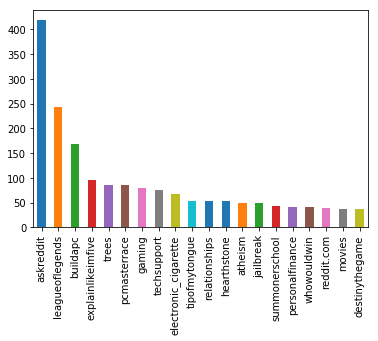

In [22]:
# Note: need this for Jupyter on local machines to work
%matplotlib inline

top_subbreddits = subreddit_counts.nlargest(20).plot.bar()
print(top_subbreddits)

### Reddit data by posts

Above we looked at statistics at the level of whole threads. 

Threads are meaningful units, but processing them can be unwieldy.  In many cases it's easier to operate at the post level because these contain the text. They are also shorter more manageable chunks of text. To do this, we will flatten the threads to make each post it's own row in the DataFrame. Below is some code the reads in the JSON data into a list and creates a frame where each row is a post (with their source thread metadata). 

In [23]:
# The reddit thread structure is nested in the posts in a new content.
# Read the file as json and create a new posts dataframe.
import json

# We will append to a list that we will convert to a DataFrame.
posts = list()

with open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    thread = json.loads(line)
    # Keep information about the source thread where the post comes from.
    for post in thread['posts']:
      posts.append((thread['subreddit'], thread['title'], post['id'], 
                    thread['url'], post.get('author', ""), 
                    post.get('body', "")))
print(len(posts))

# A post data as a DataFrame, we could also keep it as a list of tuples.
labels = ['subreddit', 'title', 'id', 'url', 'author', 'body']
post_frame = pd.DataFrame(posts, columns=labels)

110595


The output is the number of posts.  It should be about 110k posts.

#### Your task
Print out the *head* of the posts frame object.  Inspect the output to see what's in the frame and make sure it seems reasonable to you.

In [24]:
print(post_frame.head())

          subreddit                                    title          id  \
0  100movies365days                  DTX120: #87 - Nashville   t3_1bx6qw   
1  100movies365days                  DTX120: #87 - Nashville  t1_c9b2nyd   
2  100movies365days                  DTX120: #87 - Nashville  t1_c9b30i1   
3  100movies365days                  DTX120: #87 - Nashville  t1_c9b6sj0   
4           100sets  Male, 23 years old. Going for 100 sets!  t1_c3igqif   

                                                 url     author  \
0  https://www.reddit.com/r/100movies365days/comm...     DTX120   
1  https://www.reddit.com/r/100movies365days/comm...  mcgrewf10   
2  https://www.reddit.com/r/100movies365days/comm...     DTX120   
3  https://www.reddit.com/r/100movies365days/comm...  mcgrewf10   
4  https://www.reddit.com/r/100sets/comments/omv7...   Keatonus   

                                                body  
0  4/7/13  \n\n7/27/12  \n\nhttp://www.imdb.com/t...  
1  I've wanted to watch this f

#### Your task
Let's examine the question of how posts relate to threads. Each post has the thread it came from, defined by its URL.  Select the URLs and count the values.  Print out the statistical summary using describe.  *Hint:* We did something similar for the sub-reddits. 

In [26]:
print(post_frame['url'].value_counts().describe())

count    9401.000000
mean       11.764174
std         9.215183
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max        41.000000
Name: url, dtype: float64


- Critically look at these statistics.  
- What is the shortest thread, longest thread?
- How many posts are in a 'typical' thread? 
- Do they seem reasonable? What does it tell you about threads?  

#### Your task 
- Create a bar plot of the top 10 authors of reddit posts.

*Note:* Not all posts have authors. As a first step you need to `replace` all empty values in the frame with a numpy nan value `np.nan`, after doing this pandas will filter them out automatically.

In [0]:
import numpy as np 


## Text processing of reddit posts

We will now take our first steps processing the reddit posts as text.  We will apply an NLTK text processing pipeline to the posts. 



### NLTK

[NLTK](http://www.nltk.org/) is a large compilation of Python NLP packages. It includes implementations of a number of classic NLP models, as well as utilities for working with linguistic data structures, preprocessing text, and managing corpora. NLTK is included with Anaconda.  

NLTK is just one many text processing libraries. Later in the course we will try out [spaCy](https://spacy.io/).

First, let's import the library.

In [0]:
import nltk



### Step 1: Tokenization
We will try tokenization ourselves using NLTK's tokenizers. You may find the the documentation of the  [tokenize package](https://www.nltk.org/api/nltk.tokenize.html) informative.

#### Your task
Tokenize the body field of a post using a Regular Expression and Treebank tokenizer (recall this as a standard tokenizer from Penn Treebank discussed in Lecture 1) and compare them:
1.  Import the Regular Exp Tokenizer from NLTK.  
2.  Create a regular expression tokenizer that that uses a simple pattern -- a sequence of one or more "word characters". (You might need to use a search engine to help identify the right pattern to do this.)
3.  Create a tokenizer that tokenizes using the (Penn) Treebank Word tokenizer. Find the right tokenizer in the package documentation.  You may look at what other tokenizers are available.
4. Tokenize the sample post below using each of the tokenizers and print the resulting tokens for each.
5. Inspect and compare the output of the tokenizers.



In [0]:
# A sample post to tokenize. 

# Get the body text of a post from the data frame.
text = post_frame.iloc[10]['body']
print(text)

I love cheese cake! I love both making and eating it, so I'm sad to see that they usually have the most crazy calorie counts, and I don't see many low cal recipes for them especially not ones that can work for many different people (for instance, I see a lot that require sugar free Jell-O, cool whip, Neufchatel cream cheese, very specific items that aren't available everywhere).

[So here is a reciped I made!](http://imgur.com/a/z6VbS) it's very delicious, and I hope others will enjoy it too :)


In [0]:
# YOUR CODE HERE

### Tokenization matters
Tokenization is a critical first choice in developing text applications.  Below are some questions to consider when comparing the tokenizers.

- What are the key differences between the tokenizers?
- How do they treat punctuation?
- What happens to the link + URL?
- What is a 'good' vs a 'bad' okenizer?  
- How would you critically select one to use in an application? 

Are either of these tokenizers perfect? Consider how you would change the tokenizer to make it effective for the Reddit data. 

#### Your task
Create  a simple *tokenize* function that uses the regular expression tokenizer.  The function takes a string and returns the output of the tokenizer. 

- Click SHOW CODE on the cell below to see the regular expression tokenizer (it's hidden because it's part of the answer to the previous task). Execute the cell so that you can use this tokenizer in your function.



In [0]:
#@title
from nltk.tokenize import RegexpTokenizer
regexp_tokenizer = RegexpTokenizer(r'\w+')

Let's now use our tokenizer on all the posts on Reddit! 
- We use a powerful feature of Pandas called *apply* that executes a function that's passed as a parameter to every element of the series (similar to a Map operation).  
- We pass in the tokenize function to apply. 

Execute the code below. Note: this may take a minute to operate on all posts.


In [0]:

# This tokenizes the body posts and creates vector of tokens for each post.
# Note: This selections the body column from the posts only. 
all_posts_tokenized = post_frame.body.apply(tokenize)

The result is a Pandas series that contains the tokens for each post. 

For analysis, let's flatten the tokens into a single value. 



In [0]:
import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

print(flat_tokens[13:100])

## Token collection statistics

Now that we have all the tokens in the flat_tokens variable, let's use it to compute token statistics we talked about in lecture. 

#### Your task
Write come code to print the following values:
- What is the total number of tokens (N)?
- What is the average length of a post in tokens? *Hint: *How do you find the total number of posts? 

- There should be roughly 4.8 million tokens. 
- Does this seem like a reasonable average length of a post?

#### Optional task
- On all_posts_tokenized compute the length of each token.  Compute statistics beyond the mean (min, max, stddev, median, etc...)


Next, let's inspect the tokens in the collection.

#### Your Task

- Print out the 50 most frequent (common) tokens in the reddit collection with their term frequencies (TF). 
  
Use the python [collections.Counter](https://docs.python.org/2/library/collections.html) library. See it's documentation for examples on how to use it.

Look at the other functions on the Counter object.  It's a very useful library for keeping track of counts. We'll be using it again in the future. 

### Step 2: Text Normalization

In this section we will apply simple text normalization. We will write a function that takes raw tokens and normalizes them.

#### Your task

Define a python function called *normalize* that:
- Takes a sequence of *tokens* as input 
- Returns a list of *normalized tokens*
- The function should perform the following normalization: lowercasing (basic String operation) and stem the tokens using the PorterStemmer (see also the [NLTK stem package](https://www.nltk.org/api/nltk.stem.html)).

#### Apply the normalize function to the flat tokens. 
This may take a 1-2 minutes to run over the entire collection (it is over almost 5 million tokens).

In [0]:
normalized_tokens = normalize(flat_tokens)
print(normalized_tokens[13:100])

### Collect information on the vocabulary. 

#### Your task
Fill in the blanks in the code below to compute the statistics for the normalized tokens. 

Tip: Python has built-in set() function to create distinctify the values.

In [0]:
# Set of unique tokens (from flat_tokens)
B = 

# Set of unique normalized tokens --> the vocabulary
V = 

# |N| - number of all tokens
print (N)

# |B|
print( )

# |V| 
print( )

There should be approximately 140k unique raw tokens and about 86k normalized tokens. The vocabulary is significantly smaller than the number of unique raw tokens.

Let's inspect the most frequent normalized tokens.  Click SHOW CODE and execute the cell. 

In [0]:
#@title
normalized_word_count = collections.Counter(normalized_tokens)
normalized_word_count.most_common(50)

Congratulations! We now have the basic vocabulary (V) as discussed in Lecture 1. 

** Stopwords **

The most common words are functional words, often referred to as 'stop words' because they don't convey meaningful information for 'aboutness' as discussed in lecture.  In many applications we remove stopwords to remove 'noise', but in other cases they may be important to keep. You should be able to justify your decisions for when (and what) words are 'stop words'.


** Application example **

One example of where stopwords are very important is [automatic language identification](https://en.wikipedia.org/wiki/Language_identification). Language ID is a type of text classification task that we'll discuss later in the course.  In this case the words are important because stop words are not shared in common across languages, usually.  We can therefore identify text based on it's expected usage patterns of these words.  

### Text processing summary
 At this point we've done the most important parts of text processing and normalization. We have the building blocks that we can build upon to represent text in the future. 

However, you could do more effective text processing by improving the tokenization and normalization functions. Consider a few possibilities:
 - What about URLs?
 - What about improved handling of contractions (e.g. what's)
 - What about removing Stopwords as part of normalization?
 - What about removing 'junk' tokens that are too long or too short to be meaningful?
 - What about pruning the vocabulary to remove rare tokens?


### Summary

You've made good progress in this lab.  We have:
- Introduced Colab
- Learned basic libraries: Pandas, Counter, itertools, NLTK basic
- Performed basic text processing: tokenization and normalization
- Examined the structure of the Reddit dataset at the thread and post level
- Computed collection statistics on the tokens, including creating a vocabulary

In the next lab we will use these basics to represent text with one-hot encoding and bag-of-words representations and use these representations to look at post similarity and clustering. 

# Finished
Well done!

Please can you complete the feedback form for this lab on Moodle: https://moodle.gla.ac.uk/mod/feedback/view.php?id=1104426

